##  Isotop Method with swiss roll with hole dataset

reference from  https://perso.uclouvain.be/michel.verleysen/papers/icann02jl.pdf

In [1]:
import pandas as pd
import numpy as np
import random
from sklearn import datasets, manifold
from sklearn.metrics import mean_squared_error
from scipy.spatial import distance_matrix
import math
import networkx as nx
from sklearn.neighbors import kneighbors_graph

from IPython.display import clear_output
%matplotlib widget
import matplotlib.pyplot as plt
# %matplotlib inline

In [2]:
# live_plot = True
live_plot = False

In [3]:
# sr_points, sr_color = datasets.make_swiss_roll(n_samples=3000, random_state=99)
sr_points, sr_color = datasets.make_swiss_roll(n_samples=3000, hole=True, random_state=0)

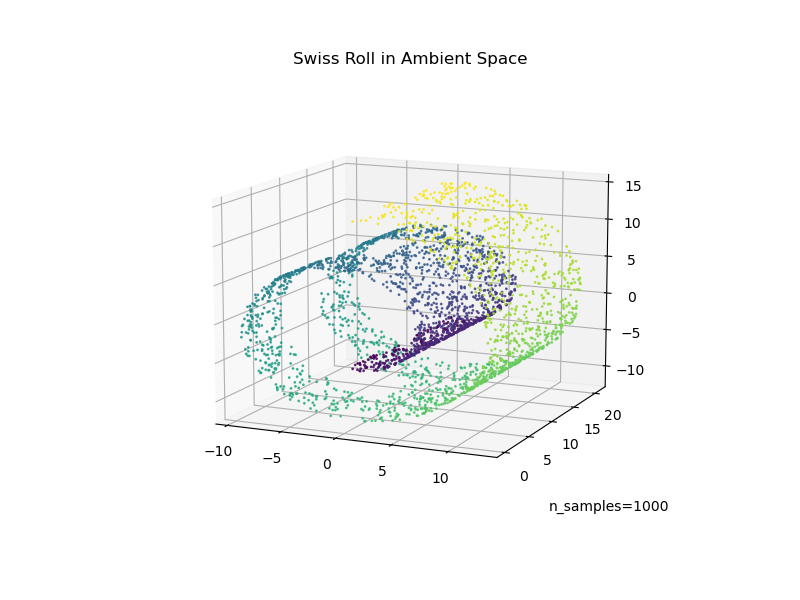

In [4]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
fig.add_axes(ax)
ax.scatter(
    sr_points[:, 0], sr_points[:, 1], sr_points[:, 2], c=sr_color, s=1, alpha=0.8
)
ax.set_title("Swiss Roll in Ambient Space")
ax.view_init(azim=-66, elev=12)
_ = ax.text2D(0.8, 0.05, s="n_samples=1000", transform=ax.transAxes)

In [5]:
n_sample = 300

mu = sr_points.mean(axis=0)
sigma = sr_points.std(axis=0)

# W = np.random.normal(mu, sigma,(n_sample,3))
rnd_index = random.sample(range(len(sr_points)), n_sample)
W = np.array([sr_points[i] for i in rnd_index]) + (np.random.normal(size=(n_sample,3))*10**-5)

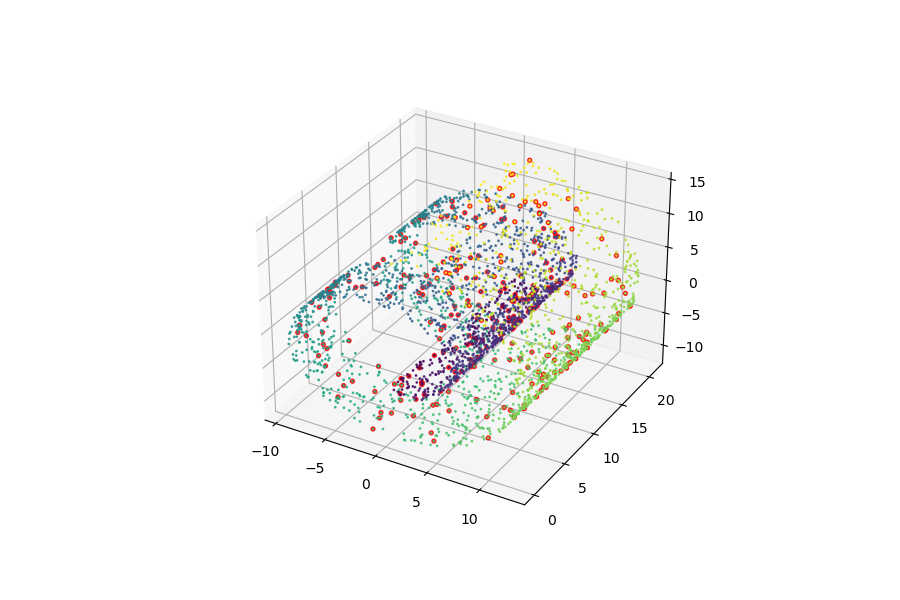

In [6]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection="3d")
fig.add_axes(ax)

# cmap = np.random.rand(len(wo),)
cmap = "red"

ax.scatter(
    sr_points[:, 0], sr_points[:, 1], sr_points[:, 2], c=sr_color, s=1, alpha=0.8
)

ax.scatter(
    W[:, 0], W[:, 1], W[:, 2], c=cmap, s=8, alpha=0.8
)

In [7]:
def decay_learning_rate(n0,t,decay=0.01):
    nt = n0/(1+decay*t)
    return nt

In [8]:
wo = W.copy()
lr = 0.7
tnow = 1
tmax = 1000

while tnow <= tmax:
    # clear_output(wait=True)
    w_prev = wo.copy()
    decay_lr = decay_learning_rate(lr,tnow,decay=0.01)
    # decay_lr = lr
    for xi in sr_points:
        # xi = sr_points[0]
        dist_wxi = distance_matrix([xi],wo)[0]
        winner_id = np.argmin(dist_wxi)
        wo[winner_id] = wo[winner_id] + decay_lr*(xi - wo[winner_id])
    mse_error = mean_squared_error(w_prev, wo)
    if mse_error < 10**-8:
        break
    # print("Epoch ..", tnow, "MSE --> ", mse_error)
    if live_plot:
        clear_output(wait=True)
        fig = plt.figure(figsize=(9, 6))
        ax = fig.add_subplot(111, projection="3d")
        fig.add_axes(ax)
        ax.scatter(
            sr_points[:, 0], sr_points[:, 1], sr_points[:, 2], c=sr_color, s=1, alpha=0.8
        )
        ax.scatter(
            wo[:, 0], wo[:, 1], wo[:, 2], c=cmap, s=4, alpha=0.8
        )
        plt.show();
    tnow += 1

In [9]:
A = kneighbors_graph(wo, 4, mode='distance')
G = nx.Graph(A)

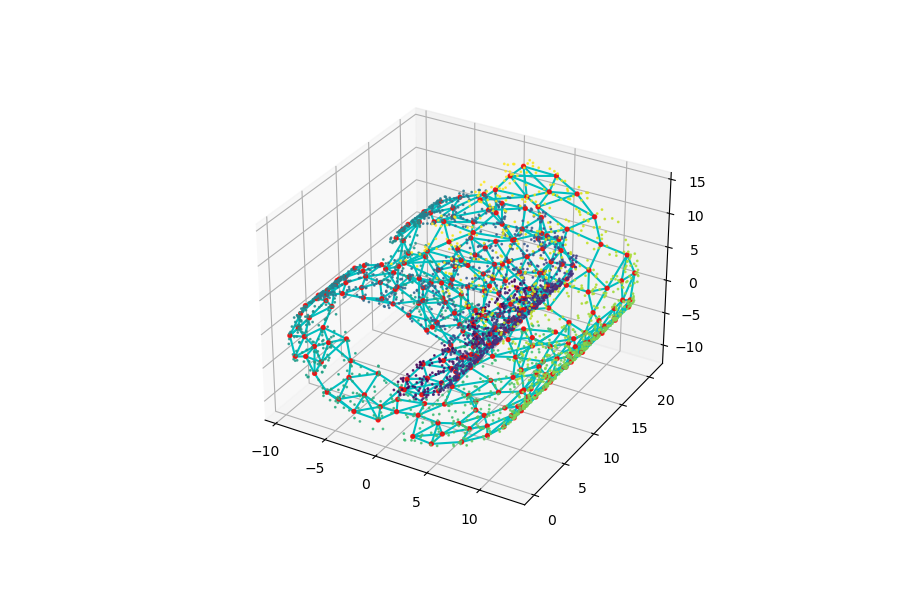

In [10]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection="3d")
fig.add_axes(ax)

# cmap = np.random.rand(len(wo),)
cmap = "red"

ax.scatter(
    sr_points[:, 0], sr_points[:, 1], sr_points[:, 2], c=sr_color, s=1, alpha=0.8
)

ax.scatter(
    wo[:, 0], wo[:, 1], wo[:, 2], c=cmap, s=8, alpha=0.8
)
for i in list(G.edges):
    cx, cy, cz = list(zip(wo[i[0]],wo[i[1]]))
    ax.plot(cx, cy, cz, 'c-')

In [11]:
Z = np.random.normal(size=(n_sample,2))

Epoch .. 4454 MSE -->  9.314290605144421e-09


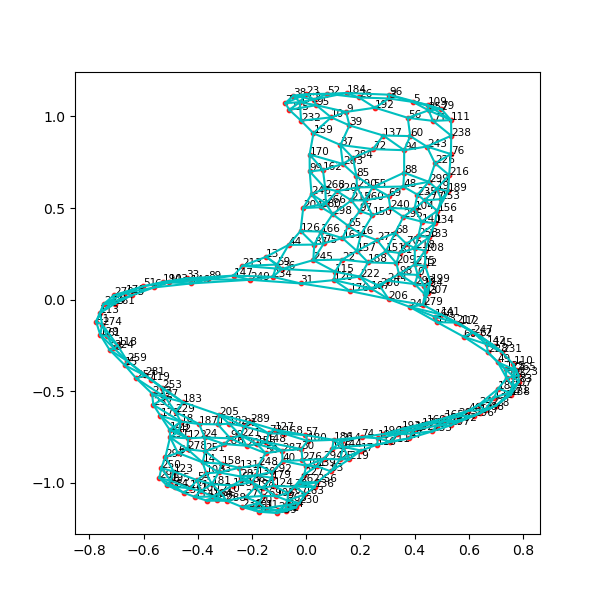

In [12]:
zo = Z.copy()
lr = 0.4
tnow = 1
tmax = 10000
lamda_0 = 300
lamda_f = 0.1

while tnow <= tmax:
    
    z_prev = zo.copy()
    
    lambda_t = lamda_0*((lamda_f/lamda_0)**(tnow/tmax))
    decay_lr = decay_learning_rate(lr,tnow,decay=0.02)
    # decay_lr = lr
    
    g = np.random.normal(size=(1,2))
    dist_gz = distance_matrix(g,zo)[0]
    winner_id = np.argmin(dist_gz)
    g_path = nx.shortest_path_length(G, source=winner_id, weight='weight')
    g_distance = [(k, v) for k, v in dict(g_path).items()]
    g_distance = sorted(g_distance, key = lambda d: d[1])
    for i, delta in g_distance:
        h_func = np.exp((-1/2)*((delta/lambda_t)**2))
        zo[i] = zo[i] + decay_lr*h_func*(g-zo[i])
    mse_error = mean_squared_error(z_prev, zo)
    if mse_error < 10**-8:
        print("Epoch ..", tnow, "MSE --> ", mse_error)
        break
    # print("Epoch ..", tnow, "MSE --> ", mse_error)
    if live_plot:
        clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(9, 6))
        ax.scatter(
            zo[:, 0], zo[:, 1], s=1, alpha=0.8
        )

        for i in list(G.edges):
            cx, cy = list(zip(zo[i[0]],zo[i[1]]))
            ax.plot(cx, cy, 'c-')
        plt.show()
    tnow += 1
    
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(
    zo[:, 0], zo[:, 1], s=10, c='red', alpha=0.8
)

for i in range(len(zo)): #plot each point + it's index as text above
    ax.text(zo[i,0],zo[i,1],  '%s' % (str(i)), size=7.5, zorder=1,  color='k')

for i in list(G.edges):
    cx, cy = list(zip(zo[i[0]],zo[i[1]]))
    ax.plot(cx, cy, 'c-')
plt.show()

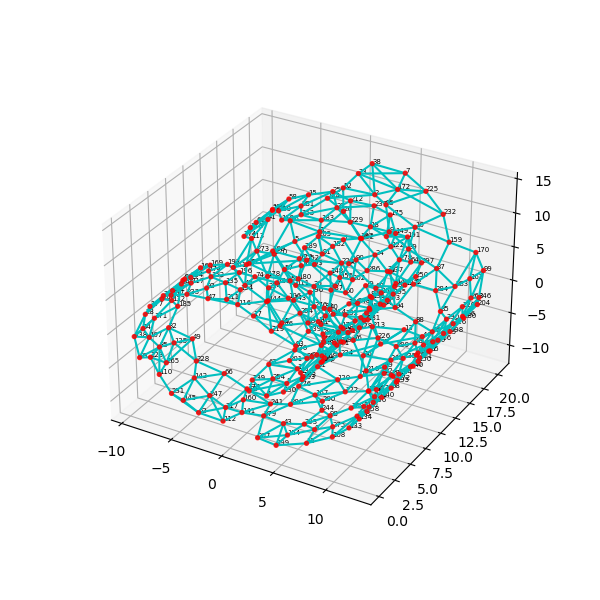

In [13]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d")
fig.add_axes(ax)

# cmap = np.random.rand(len(wo),)
cmap = "red"

# ax.scatter(
#     sr_points[:, 0], sr_points[:, 1], sr_points[:, 2], c=sr_color, s=1, alpha=0.8
# )

ax.scatter(
    wo[:, 0], wo[:, 1], wo[:, 2], c=cmap, s=8, alpha=0.8
)
for i in range(len(wo)): #plot each point + it's index as text above
    ax.text(wo[i,0],wo[i,1],wo[i,2],  '%s' % (str(i)), size=5, zorder=1,  color='k')
    
for i in list(G.edges):
    cx, cy, cz = list(zip(wo[i[0]],wo[i[1]]))
    ax.plot(cx, cy, cz, 'c-')